# ATHENA with Customer Survey Data
Using FY18 Flight Data and FY18 Customer Survey Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kendalltau
from scipy.stats import pearsonr

import statsmodels.api as sm
from statsmodels.formula.api import ols

from matplotlib.colors import LogNorm

Note: This notebook references data that is sensitive. Email Monte Lunacek (Monte.Lunacek@nrel.gov) or Lindy Williams (Lindy.Williams@nrel.gov) for access.

In [5]:
cs = pd.read_csv('/data/CSRawData.csv')
flights = pd.read_csv('/data/DFW_flights_FY18_complete.csv')

In [6]:
# data prep for analysis
cs2 = cs.copy()

cs2['month_year'] = cs2["Calendar Month"].replace(["February -2018", "March    -2018", "April    -2018", "May      -2018", "June     -2018",
                    "July     -2018", "August   -2018", "September-2018", "October  -2018", "November -2018",
                    "December -2018", "January  -2018", "October  -2017", "November -2017",
                    "December -2017"],["201802", "201803", "201804", "201805", "201806", "201807", 
                                       "201808", "201809", "201810", "201811", "201812", "201801", 
                                       "201710", "201711", "201712"])

cs2['connecting'] = np.where(cs['Passenger Type']!= "Connecting", 0, 1)
cs2 = cs2[cs2["connecting"] == 0]
storage = cs2['Survey Time'].str.split(" ", n = 1, expand = True) 
cs2['year_month_day'] = storage[0]
cs2['time'] = storage[1]
storage = cs2['year_month_day'].str.split("-", n = 2, expand = True) 
storage2 = cs2['time'].str.split(":", n = 2, expand = True)
cs2['day'] = storage[0].astype(int)
cs2['month'] = storage[1]
cs2['year'] = '20' + storage[2]
cs2['year'] = cs2['year'].astype(int) 
cs2["month"] = cs2["month"].replace(["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"],
                                      ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']).astype(int)
cs2['year_month'] = cs2['year'] * 100 + cs2['month'] 
cs2['year_month_day'] = cs2['year'].astype(str)  + '-' + cs2['month'].astype(str)  + '-' + cs2['day'].astype(str) 
cs2['day_of_week'] = pd.to_datetime(cs2['year_month_day']).dt.dayofweek
cs2['Terminal Curbside Area - Sum'] = cs2['Terminal Curbside Area - Sum'].replace(' ', np.nan)
cs2 = cs2.astype({"Terminal Curbside Area - Sum": np.float16})
cs2 = cs2[cs2["Passenger Type"] == 'Originating']
cs2018 = cs2[cs2["year"] == 2018]
cs2018 = cs2018[cs2018["month"] <= 9]
cs2017 = cs2[cs2["year"] == 2017]
cs2017 = cs2017[cs2017["month"] >= 10]
cs2 = pd.concat([cs2018,cs2017])

In [7]:
# looking at the data for values of 2 or less
twoorless = cs2[cs2["Terminal Curbside Area - Sum"] <= 2.0].groupby(['year','month']).count()[['Survey Sequence']].reset_index()
twoorless['total'] = twoorless['Survey Sequence'].sum()
twoorless['prop'] = twoorless['Survey Sequence']/twoorless['total']
twoorless['year_month'] = twoorless['year'] *100 + twoorless['month']
twoorless

,year,month,Survey Sequence,total,prop,year_month
0,2017,10,8,87,0.091954,201710
1,2017,11,9,87,0.103448,201711
2,2017,12,10,87,0.114943,201712
3,2018,1,6,87,0.068966,201801
4,2018,2,6,87,0.068966,201802
5,2018,3,7,87,0.080460,201803
6,2018,4,5,87,0.057471,201804
7,2018,5,6,87,0.068966,201805
8,2018,6,7,87,0.080460,201806
9,2018,7,9,87,0.103448,201807


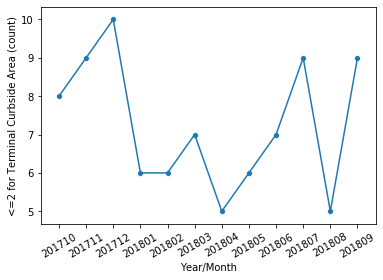

In [8]:
# data prep for plot
labels = ['201710', '201711', '201712', '201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808', '201809']
twoorless['year_month_str'] = twoorless['year_month'].astype(str)
m = twoorless_plot = sns.lineplot(x="year_month_str", y="Survey Sequence", data=twoorless, palette="Blues")
m = twoorless_plot = sns.scatterplot(x="year_month_str", y="Survey Sequence", data=twoorless)
m = twoorless_plot.set_xlabel('Year/Month')
m = twoorless_plot.set_ylabel('<=2 for Terminal Curbside Area (count)')
m = twoorless_plot.set_xticklabels(labels, rotation =30)

In [9]:
# adding in aggregate values for the customer satisfaction data
cs2_agg = cs2.groupby(["year","month","day"])[["Terminal Curbside Area - Sum"]].mean().reset_index()
cs2_agg = cs2_agg.rename(columns={"Terminal Curbside Area - Sum": "Terminal Curbside Area - Sum_mean"})
cs2_agg['Curbside_median'] = cs2.groupby(["year","month","day"])[["Terminal Curbside Area - Sum"]].median().reset_index()["Terminal Curbside Area - Sum"]
cs2_agg['Curbside_min'] = cs2.groupby(["year","month","day"])[["Terminal Curbside Area - Sum"]].min().reset_index()["Terminal Curbside Area - Sum"]
cs2_agg['Curbside_max'] = cs2.groupby(["year","month","day"])[["Terminal Curbside Area - Sum"]].max().reset_index()["Terminal Curbside Area - Sum"]
cs2_agg["Overall Satisfaction - Sum_mean"] = cs2.groupby(["year","month","day"])[['Overall Satisfaction - Sum']].mean().reset_index()['Overall Satisfaction - Sum']
cs2_agg["Overall_median"] = cs2.groupby(["year","month","day"])[['Overall Satisfaction - Sum']].median().reset_index()['Overall Satisfaction - Sum']
cs2_agg["Overall_min"] = cs2.groupby(["year","month","day"])[['Overall Satisfaction - Sum']].min().reset_index()['Overall Satisfaction - Sum']
cs2_agg["Overall_max"] = cs2.groupby(["year","month","day"])[['Overall Satisfaction - Sum']].max().reset_index()['Overall Satisfaction - Sum']

In [10]:
# flight data prep
flights['flight_time'] = pd.to_datetime(flights['flight_time'])
flights['flight_sched_time'] = pd.to_datetime(flights['flight_sched_time'])
flights['delay'] = flights['flight_time'] - flights['flight_sched_time']
flights['delay_seconds'] = flights['delay']/np.timedelta64(1,'s')
flights['delay_mins'] = flights['delay_seconds']/60.0

# a negative delay value can be interpreted as the plane landing before the scheduled time
# going to filter on passenger flights
flights = flights[flights['flight_type'] == 'PAX']
flights['year'] = flights['flight_time'].dt.year
flights['month'] = flights['flight_time'].dt.month
flights['day'] = flights['flight_time'].dt.day
flights['day_of_week'] = flights['flight_time'].dt.dayofweek
flights['scheduled_hour'] = flights['flight_sched_time'].dt.hour

In [11]:
flights_agg = flights.groupby(["year","month","day"])[['delay_mins']].mean().reset_index()
flights_agg["num_flights"] = flights.groupby(["year","month","day"])[['flight_id']].count().reset_index()['flight_id']

# Correlations for select variables aggregated on a daily basis

In [12]:
# function that will run kendall tau correlation on two given columns and round to 2 decimals
def runkt(x, y, pval = True):
    if pval == True:
        return round(kendalltau(cs_flights[x], cs_flights[y])[0], 2)
    else:
        return kendalltau(cs_flights[x], cs_flights[y])[1]

In [13]:
cs_flights = cs2_agg.merge(flights_agg, left_on=['day','month','year'], right_on=['day','month','year'], how='inner')

In [14]:
col_names = ['delay_mins', 'num_flights', 'Curbside_min', 'Curbside_median', 'Curbside_max', 'Overall_min', 'Overall_median', 'Overall_max']

x = ["Delays (mins)", "num_flights", "Terminal Curbside min", "Terminal Curbside median",
              "Terminal Curbside max", "Overall min", "Overall median",
              "Overall max"]

y = ["Delays (mins)", "num_flights", "Terminal Curbside min", "Terminal Curbside median",
              "Terminal Curbside max", "Overall min", "Overall median",
              "Overall max"]

for i in col_names:
    for j in col_names:
        if i != j:
            p_val = runkt(i, j, False)
            if p_val < .05:
                print(p_val, i, j)

2.0934617337072573e-11 delay_mins num_flights
2.0934617337072573e-11 num_flights delay_mins
0.03429041859180038 num_flights Curbside_min
0.03429041859180038 Curbside_min num_flights
1.0240051299699822e-14 Curbside_min Curbside_median
3.73861889691418e-18 Curbside_min Overall_min
1.40447344177604e-09 Curbside_min Overall_median
1.0240051299699822e-14 Curbside_median Curbside_min
8.223212946312559e-09 Curbside_median Curbside_max
2.2568629143150616e-11 Curbside_median Overall_min
7.151131845048404e-27 Curbside_median Overall_median
7.231219413018438e-05 Curbside_median Overall_max
8.223212946312559e-09 Curbside_max Curbside_median
2.69096213647844e-07 Curbside_max Overall_median
1.3483556484425439e-21 Curbside_max Overall_max
3.73861889691418e-18 Overall_min Curbside_min
2.2568629143150616e-11 Overall_min Curbside_median
3.2471913731589068e-22 Overall_min Overall_median
1.40447344177604e-09 Overall_median Curbside_min
7.151131845048404e-27 Overall_median Curbside_median
2.69096213647844e

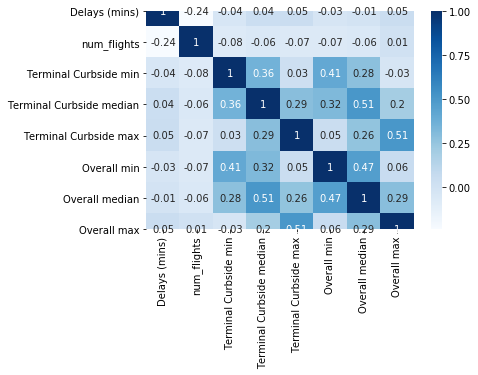

In [15]:
l = col_names
sns.heatmap(np.array([[1.0, runkt(l[0],l[1]), runkt(l[0],l[2]), runkt(l[0],l[3]), runkt(l[0],l[4]), runkt(l[0],l[5]), runkt(l[0],l[6]), runkt(l[0],l[7])],
                    [runkt(l[0],l[1]), runkt(l[1],l[1]), runkt(l[1],l[2]), runkt(l[1],l[3]), runkt(l[1],l[4]), runkt(l[1],l[5]), runkt(l[1],l[6]), runkt(l[1],l[7])],
                    [runkt(l[2],l[0]), runkt(l[2],l[1]), runkt(l[2],l[2]), runkt(l[2],l[3]), runkt(l[2],l[4]), runkt(l[2],l[5]), runkt(l[2],l[6]), runkt(l[2],l[7])],
                    [runkt(l[3],l[0]), runkt(l[3],l[1]), runkt(l[3],l[2]), runkt(l[3],l[3]), runkt(l[3],l[4]), runkt(l[3],l[5]), runkt(l[3],l[6]), runkt(l[3],l[7])],
                    [runkt(l[4],l[0]), runkt(l[4],l[1]), runkt(l[4],l[2]), runkt(l[4],l[3]), runkt(l[4],l[4]), runkt(l[4],l[5]), runkt(l[4],l[6]), runkt(l[4],l[7])],
                    [runkt(l[5],l[0]), runkt(l[5],l[1]), runkt(l[5],l[2]), runkt(l[5],l[3]), runkt(l[5],l[4]), runkt(l[5],l[5]), runkt(l[5],l[6]), runkt(l[5],l[7])],
                    [runkt(l[6],l[0]), runkt(l[6],l[1]), runkt(l[6],l[2]), runkt(l[6],l[3]), runkt(l[6],l[4]), runkt(l[6],l[5]), runkt(l[6],l[6]), runkt(l[6],l[7])],
                    [runkt(l[7],l[0]), runkt(l[7],l[1]), runkt(l[7],l[2]), runkt(l[7],l[3]), runkt(l[7],l[4]), runkt(l[7],l[5]), runkt(l[7],l[6]), runkt(l[7],l[7])]]), xticklabels = x, yticklabels = y, annot=True, cmap="Blues")

We can see the relationships with higher correlations in darker colors.

In [17]:
# exploring the continuous variables with kendall tau

coef, p = kendalltau(cs_flights["delay_mins"], cs_flights["num_flights"])
print(coef, p)

-0.23813574847429753 2.0934617337072573e-11


In [18]:
# exploring the same relationship with pearsons

corr, p = pearsonr(cs_flights["delay_mins"], cs_flights["num_flights"])
print(corr, p)

-0.4105371688009409 6.603973167015587e-16


In [19]:
# testing ANOVA to link num_flights and the curbside min value

moore_lm = ols('num_flights ~ C(Curbside_min)', data=cs_flights).fit()
table = sm.stats.anova_lm(moore_lm, typ=1) # Type 2 ANOVA DataFrame

print(moore_lm.summary())

                            OLS Regression Results                            
Dep. Variable:            num_flights   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.085
Date:                Wed, 25 Sep 2019   Prob (F-statistic):             0.0823
Time:                        17:54:34   Log-Likelihood:                -2269.3
No. Observations:                 356   AIC:                             4549.
Df Residuals:                     351   BIC:                             4568.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1594

# Overall Median and Curbside Median Relationship: 
Correlation: 0.51

In [20]:
overall_and_curbside = pd.crosstab(cs_flights.Curbside_median, cs_flights.Overall_median)

In [21]:
overall_and_curbside

Overall_median,3.0,3.5,4.0,4.5,5.0
Curbside_median,,,,,
3.0,5,3,4,0,0
3.5,1,3,7,2,0
4.0,2,2,120,17,23
4.5,0,0,13,10,10
5.0,0,0,40,9,85


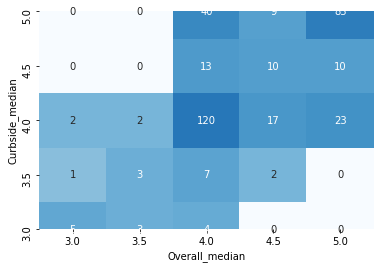

In [22]:
cs_flights.sort_index(axis=0, ascending=False, inplace=True)

ax = sns.heatmap(pd.crosstab(cs_flights.Curbside_median, cs_flights.Overall_median)+.001, norm=LogNorm(pd.crosstab(cs_flights.Curbside_median, cs_flights.Overall_median).min().min(),pd.crosstab(cs_flights.Curbside_median, cs_flights.Overall_median).max().max()),
            cbar_kws={"ticks":[0,1,10,1e2,1e3,1e4,1e5]},
            vmin = 0.001, vmax=10000, annot=True, fmt='.0f', cbar=False, cmap="Blues")
ax.invert_yaxis()
plt.show()

Heatmap looking at the relationship between Overall median and Curbside median counts.

# Number of Flights and Delay (mins) Relationship: 
Correlation: -0.24

In [23]:
sns.set(style="darkgrid")

Text(16.0, 0.5, 'Number of Flights')

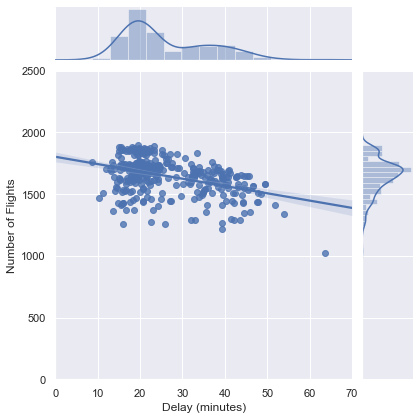

In [24]:
flight_and_delay = sns.jointplot("delay_mins", "num_flights", data=cs_flights, kind="reg",
                  xlim=(0, 70), ylim=(0, 2500), height=6)
flight_and_delay.ax_joint.set_xlabel('Delay (minutes)')
flight_and_delay.ax_joint.set_ylabel('Number of Flights')

# Number of Flights & Terminal Curbside Satisfaction Relationship: 
Correlation: -0.08

In [25]:
def custom_round(x, base=5):
    return int(base * round(float(x)/base))

In [26]:
cs_flights['round_num_flights'] = cs_flights['num_flights'].apply(lambda x: custom_round(x, base=15))
cs_flights_grouped2 = cs_flights.groupby(['round_num_flights'])[["Curbside_min"]].median().reset_index()

Text(0, 0.5, 'Terminal Curbside Area - Min')

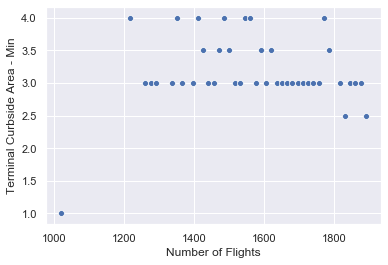

In [27]:
flight_and_curb = sns.scatterplot(x="round_num_flights", y="Curbside_min", data=cs_flights_grouped2)
flight_and_curb.set_xlabel('Number of Flights')
flight_and_curb.set_ylabel('Terminal Curbside Area - Min')

Text(0, 0.5, 'Terminal Curbside Area - Min')

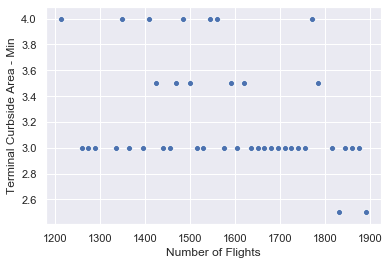

In [28]:
# getting rid of the outliers
cs_flights_grouped3 = cs_flights_grouped2[cs_flights_grouped2['Curbside_min'] > 1.5]

flight_and_curb = sns.scatterplot(x="round_num_flights", y="Curbside_min", data=cs_flights_grouped3)
flight_and_curb.set_xlabel('Number of Flights')
flight_and_curb.set_ylabel('Terminal Curbside Area - Min')

# Additional Analysis:
Delays by month

[Text(0, 0, '201710'),
 Text(0, 0, '201711'),
 Text(0, 0, '201712'),
 Text(0, 0, '201801'),
 Text(0, 0, '201802'),
 Text(0, 0, '201803'),
 Text(0, 0, '201804'),
 Text(0, 0, '201805'),
 Text(0, 0, '201806'),
 Text(0, 0, '201807'),
 Text(0, 0, '201808'),
 Text(0, 0, '201809')]

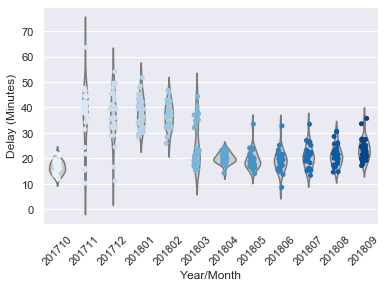

In [29]:
# using the joined data (delay in minutes mean by month)

cs3 = cs_flights
cs3['year_month'] = cs3['year']*100 + cs3['month']
delay_by_month = sns.stripplot(x="year_month", y="delay_mins", data=cs3, palette="Blues")
delay_by_month = sns.violinplot(x="year_month", y="delay_mins", data=cs3, inner=None, color = '.8', cmap="Blues")
delay_by_month.set_xlabel('Year/Month')
delay_by_month.set_ylabel('Delay (Minutes)')
delay_by_month.set_xticklabels(delay_by_month.get_xticklabels(), rotation=45)

We can see more spread in delays in November and December.